# <font color = 'indianred'>**Binary Classification With GEMMA** </font>

## Overview
This notebook demonstrates a complete pipeline for **binary text classification** using Google's GEMMA-2-2B model with advanced fine-tuning techniques. We leverage **QLoRA (Quantized Low-Rank Adaptation)** for efficient parameter-efficient fine-tuning and add a **classification head** for binary decision-making.

## Objective
Binary Classification using GEMMA with Classification Head and QLoRA

## Key Concepts
- **GEMMA**: A lightweight, open-source language model by Google optimized for efficiency
- **Binary Classification**: Task of classifying text into one of two categories (e.g., rule-compliant vs. rule-violating)
- **QLoRA (Quantized LoRA)**: Combines 4-bit quantization with LoRA for memory-efficient fine-tuning
- **Classification Head**: A simple linear layer added on top of the base model for classification
- **Threshold Optimization**: Fine-tuning the decision boundary to maximize F1 score

## Workflow
1. Environment setup and library imports
2. Data loading and preprocessing
3. Data splitting (train/validation/test - 80/10/10)
4. Tokenization using GEMMA's tokenizer
5. Model loading with 4-bit quantization
6. LoRA configuration and model preparation
7. Training with weighted BCE loss (for class imbalance)
8. Validation and threshold optimization
9. Test set evaluation
10. Model inference on competition data

# <font color = 'indianred'> **1. Setting up the Environment** </font>

## Theory & Explanation
Before starting model training, we need to set up the computational environment with necessary libraries and GPU resources.

### Key Components:
- **GPU Setup**: Check CUDA availability for faster training using `nvidia-smi`
- **Core Libraries**:
  - `transformers`: HuggingFace library for pre-trained models and training utilities
  - `peft`: Parameter-Efficient Fine-Tuning library for LoRA implementation
  - `bitsandbytes`: Enables 4-bit quantization for memory-efficient training
  - `datasets`: HuggingFace library for efficient dataset handling
  - `wandb`: Weights & Biases for experiment tracking and visualization
  - `torch`: PyTorch deep learning framework
  - `sklearn`: Scikit-learn for metrics and utilities

### Why These Libraries?
- **Transformers** provides state-of-the-art models with easy-to-use APIs
- **PEFT** allows training large models on limited GPU memory
- **BitsAndBytes** reduces memory usage by 75% through 4-bit quantization
- **WandB** helps track experiments, hyperparameters, and visualize training progress

In [141]:
!nvidia-smi
#import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
     !pip install numpy -U -qq
     !pip install transformers evaluate wandb datasets accelerate trl peft bitsandbytes -U -qq

Sun Nov  2 18:38:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   33C    P0             61W /  400W |   11239MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

 <Font size = 5 color = 'indianred'>**Restart the session before moving onto next cell**
> Runtime- Restart Session

In [1]:
# ============================================================================
# WANDB CONFIGURATION
# ============================================================================

WANDB_PROJECT = "jigsaw-binary-classification-fa2025"
WANDB_ENTITY = "Jigsaw-Classification" # **Please replace "your_team_name" with your actual WandB team name.**
# Experiment configuration
experiment_config = {
    "model_name": "google/gemma-2-2b",
    "approach": "classification_head",
    "task": "binary_classification",
    "num_labels": 2,
    "dataset": "jigsaw-agile-community-rules",
    "train_samples": None,  # Will be updated
    "val_samples": None,
    "test_samples": None,
    "batch_size": 32,
    "learning_rate": 1e-5,
    "num_epochs": 3,
    "lora_r": 128,
    "lora_alpha": 256,
    "optimizer": "adamw_torch",
    "weight_decay": 0.01,
}

print(f"WandB Project: {WANDB_PROJECT}")
print(f"WandB Entity: {WANDB_ENTITY}")

WandB Project: jigsaw-binary-classification-fa2025
WandB Entity: Jigsaw-Classification


<font color = 'indianred'> *Load Libraries* </font>

## Description
Import all necessary Python libraries for data processing, model training, evaluation, and experiment tracking.

In [2]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score
)
import seaborn as sns
from pathlib import Path
import re
import gc
import time
from sklearn.model_selection import train_test_split
import joblib
import torch
import torch.nn as nn

# HuggingFace libraries
import evaluate
from datasets import load_dataset, DatasetDict, Dataset
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
    AutoPeftModelForSequenceClassification,
    PeftConfig
)

import wandb
from google.colab import userdata
from huggingface_hub import login, HfApi, create_repo
from typing import Optional, List
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

In [3]:
# Set seed for reproducibility
set_seed(42)

In [4]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')


In [5]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")


Successfully logged in to Hugging Face!


In [6]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: talktothewhitehat (Jigsaw-Classification) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Successfully logged in to WANDB!


# <font color = 'indianred'> **2. Load Data set**</font>

## Theory & Explanation

### Data Loading Strategy
The dataset for this task is the **Jigsaw Agile Community Rules** dataset, containing comments and binary labels indicating whether comments violate community rules.

### Dataset Characteristics:
- **Training Data**: Contains comments, rules, and violation labels
- **Test Data**: Competition test set for final predictions
- **Task**: Binary classification of community comments against specific rules

### Key Features:
- `body`: The text of the comment to be classified
- `rule`: The specific rule to check against
- `rule_violation`: Binary label (0 = complies, 1 = violates)
- Class balance is critical - we need to handle imbalanced data

### Data Exploration Steps:
1. Load CSV files into pandas DataFrames
2. Examine data shape and columns
3. Visualize class distribution
4. Identify potential data imbalance issues

In [7]:
# If running on Google Colab, use Google Drive as storage
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS

if 'google.colab' in str(get_ipython()):
    from google.colab import drive  # Import Google Drive mounting utility
    drive.mount('/content/drive')  # Mount Google Drive

    # Set base folder path for storing data on Google Drive
base_folder= Path('/content/drive/MyDrive/datasets')
project_folder = Path('/content/drive/MyDrive/AI/')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data_folder = base_folder/'jigsaw-agile-community-rules'
dataset = load_dataset('csv', data_files={'train': str(data_folder/'train.csv')})
train_df = pd.read_csv(data_folder/'train.csv')
test_competition_df = pd.read_csv(data_folder/'test.csv')


In [9]:
print(f"Training data shape: {train_df.shape}")
print(f"Competition test data shape: {test_competition_df.shape}")
print("\nTraining data columns:", train_df.columns.tolist())
print("\nFirst few rows:")
print(train_df.head())

Training data shape: (2029, 9)
Competition test data shape: (10, 8)

Training data columns: ['row_id', 'body', 'rule', 'subreddit', 'positive_example_1', 'positive_example_2', 'negative_example_1', 'negative_example_2', 'rule_violation']

First few rows:
   row_id                                               body  \
0       0  Banks don't want you to know this! Click here ...   
1       1  SD Stream [ ENG Link 1] (http://www.sportsstre...   
2       2  Lol. Try appealing the ban and say you won't d...   
3       3  she will come your home open her legs with  an...   
4       4  code free tyrande --->>> [Imgur](http://i.imgu...   

                                                rule      subreddit  \
0  No Advertising: Spam, referral links, unsolici...     Futurology   
1  No Advertising: Spam, referral links, unsolici...  soccerstreams   
2  No legal advice: Do not offer or request legal...   pcmasterrace   
3  No Advertising: Spam, referral links, unsolici...            sex   
4  No

In [10]:
print("\nClass distribution in training data:")
print(train_df['rule_violation'].value_counts())
print(f"\nClass balance: {train_df['rule_violation'].value_counts(normalize=True)}")


Class distribution in training data:
rule_violation
1    1031
0     998
Name: count, dtype: int64

Class balance: rule_violation
1    0.508132
0    0.491868
Name: proportion, dtype: float64


# <font color = 'indianred'> **3. Accessing and Manipulating Data Splits**</font>

## Theory & Explanation

### Data Splitting Strategy
We need to create separate train, validation, and test sets to properly evaluate model performance and prevent data leakage.

### Split Proportions (80/10/10):
- **Training Set (80%)**: Used to train the model parameters
- **Validation Set (10%)**: Used during training to validate and tune hyperparameters
- **Test Set (10%)**: Held out completely, used only for final evaluation

### Why This Matters:
- **Training set** teaches the model patterns
- **Validation set** helps monitor overfitting and tune thresholds
- **Test set** provides unbiased performance estimate
- **Stratification** ensures class distribution is consistent across all splits

### Text Preprocessing:
We combine multiple fields (comment body + rule) into a single input text, separated by `[SEP]` token, providing richer context to the model.

### Creating Further Subdivisions of the Splits

After initial splitting, we further subdivide the data to create structured subsets for different purposes.

<font color = 'indianred'>*Text Preprocessing Functions*</font>

## Description
Define helper functions to preprocess and combine text fields into unified input format for the model.

In [11]:
def preprocess_text(text):
    """Basic text preprocessing"""
    if pd.isna(text):
        return ""
    # Convert to string and strip whitespace
    text = str(text).strip()
    return text

In [12]:
def create_input_text(row):
    """
    Create input text combining comment, rule, and examples
    This helps the model understand the context better
    """
    text_parts = []

    # Add the comment body
    text_parts.append(f"Comment: {preprocess_text(row['body'])}")

    # Add the rule
    text_parts.append(f"Rule: {preprocess_text(row['rule'])}")

    # add examples #TODO
    # text_parts.append(f"Positive Example: {preprocess_text(row['positive_example_1'])}")
    # text_parts.append(f"Negative Example: {preprocess_text(row['negative_example_1'])}")

    return " [SEP] ".join(text_parts)

In [13]:
# Split the test set into test and validation sets
train_df['text'] = train_df.apply(create_input_text, axis=1)
train_df['label'] = train_df['rule_violation'].astype(int)


In [14]:
# Create train/validation/test splits (80/10/10)
train_val_df, test_df = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df['label']
)

train_df_split, val_df = train_test_split(
    train_val_df,
    test_size=0.111,  # 0.111 of 90% ≈ 10% of total
    random_state=42,
    stratify=train_val_df['label']
)

In [15]:
print(f"\nTrain set size: {len(train_df_split)} ({len(train_df_split)/len(train_df)*100:.1f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(train_df)*100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(train_df)*100:.1f}%)")

print("\nClass distribution:")
print(f"Train: {train_df_split['label'].value_counts().to_dict()}")
print(f"Val: {val_df['label'].value_counts().to_dict()}")
print(f"Test: {test_df['label'].value_counts().to_dict()}")


Train set size: 1623 (80.0%)
Validation set size: 203 (10.0%)
Test set size: 203 (10.0%)

Class distribution:
Train: {1: 825, 0: 798}
Val: {1: 103, 0: 100}
Test: {1: 103, 0: 100}


In [16]:
# Create HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df_split[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

In [17]:
dataset_dict = DatasetDict({
    "train": train_dataset,
    "valid": val_dataset,
    "test": test_dataset
})

In [18]:
print("\nDataset Dictionary:")
print(dataset_dict)


Dataset Dictionary:
DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 1623
    })
    valid: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 203
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 203
    })
})


In [19]:
dataset['train'].features

{'row_id': Value('int64'),
 'body': Value('string'),
 'rule': Value('string'),
 'subreddit': Value('string'),
 'positive_example_1': Value('string'),
 'positive_example_2': Value('string'),
 'negative_example_1': Value('string'),
 'negative_example_2': Value('string'),
 'rule_violation': Value('int64')}

<font color = 'indianred'>*Small Subset for Initial Experimentation*</font>

## Description
For rapid experimentation and debugging, we can use a small subset of the data instead of the full dataset. This allows for faster training cycles when testing new ideas.

### Benefits of Subset Training:
- **Faster iteration**: Train and test ideas quickly
- **Memory efficiency**: Reduces GPU memory requirements
- **Debugging**: Easier to spot issues in the pipeline
- **Hyperparameter tuning**: Test different configurations faster

Set `USE_SUBSET = True` to use only 2000 training samples, 1000 validation samples, and 1000 test samples.

In [20]:
USE_SUBSET = False # Set True for subset
# Set to False for full training
if USE_SUBSET:
    subset_size = 2000
    dataset_dict["train"] = dataset_dict["train"].shuffle(seed=42).select(range(min(subset_size, len(dataset_dict["train"]))))
    dataset_dict["valid"] = dataset_dict["valid"].shuffle(seed=42).select(range(min(1000, len(dataset_dict["valid"]))))
    dataset_dict["test"] = dataset_dict["test"].shuffle(seed=42).select(range(min(1000, len(dataset_dict["test"]))))
    print(f"\nUsing subset of data for experimentation:")
    print(dataset_dict)

# <font color = 'indianred'>**4. Load Pre-trained Tokenizer**</font>

## Theory & Explanation

### What is a Tokenizer?
A tokenizer converts raw text into numerical tokens that the model can process. It:
1. **Splits text** into subword units (tokens)
2. **Maps tokens** to integer IDs using a vocabulary
3. **Handles special tokens** like padding and attention masks
4. **Applies model-specific rules** for processing

### Why Use Pre-trained Tokenizers?
- **Vocabulary Alignment**: The tokenizer vocabulary must match the model's training vocabulary
- **Subword Tokenization**: Uses BPE (Byte Pair Encoding) to handle rare words efficiently
- **Special Tokens**: Includes task-specific tokens like padding and unknown tokens

### GEMMA Tokenizer Specifics:
- **Vocabulary Size**: ~250K tokens
- **Padding Token**: Set to end-of-sequence token when not defined
- **Max Length**: Typically 512 tokens for efficient processing

### Memory Management:
The `free_gpu_memory()` function clears GPU cache between major operations to prevent out-of-memory errors, crucial for working with large models.

In [21]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [22]:
free_gpu_memory()

GPU memory has been freed.


In [23]:
#Load Pre-trained Tokenizer
checkpoint = "google/gemma-2-2b"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [25]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [26]:
print(f"Tokenizer loaded: {checkpoint}")
print(f"Vocab size: {len(tokenizer)}")
print(f"Pad token: {tokenizer.pad_token}")

Tokenizer loaded: google/gemma-2-2b
Vocab size: 256000
Pad token: <pad>


#<font color = 'indianred'> **5. Tokenization Strategy**</font>

## Theory & Explanation

### Tokenization Function
We create a reusable function that:
1. **Tokenizes text** using the GEMMA tokenizer
2. **Applies truncation** to limit sequence length (512 tokens max)
3. **Adds padding** to create uniform batch sizes
4. **Returns PyTorch tensors** compatible with the model

### Parameters Explained:
- **truncation=True**: Cuts texts longer than 512 tokens
- **max_length=512**: Sets maximum sequence length
- **padding='max_length'**: Pads all sequences to the same length

### Why Truncation & Padding?
- **Truncation**: Prevents memory overflow with long sequences
- **Padding**: Creates uniform batch sizes for efficient GPU processing
- **Attention masks**: Automatically generated to ignore padding tokens

## Applying Tokenization to Dataset

Use the HuggingFace `map` function to efficiently apply tokenization across the entire dataset.

In [27]:
def tokenize_fn(batch):
    """Tokenize the text with truncation and padding"""
    return tokenizer(
        text=batch["text"],
        truncation=True,
        max_length=512,
        padding='max_length'
    )

<font color = 'indianred'> *Apply Tokenization to All Dataset Splits*</font>

## Description
Use the HuggingFace `map` function to efficiently apply tokenization across the entire dataset.

### Process:
1. **Batched tokenization**: Process multiple samples at once for efficiency
2. **Remove text column**: Drop original text after tokenization (to save memory)
3. **Set PyTorch format**: Convert to PyTorch tensors for training
4. **Format conversions**: Transform labels to float for BCEWithLogitsLoss compatibility

In [28]:
# Apply tokenization
tokenized_dataset = dataset_dict.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['text'])
tokenized_dataset.set_format(type='torch')


Map:   0%|          | 0/1623 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

In [29]:
# Convert labels to float for BCEWithLogitsLoss
tokenized_dataset = (tokenized_dataset
    .map(lambda x: {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
    .rename_column("float_label", "label"))

Map:   0%|          | 0/1623 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

In [30]:
print("\nTokenized dataset:")
print(tokenized_dataset)
print(f"\nSample tokenized input shape: {tokenized_dataset['train']['input_ids'][0].shape}")
print(f"Sample label: {tokenized_dataset['train']['label'][0]}")


Tokenized dataset:
DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'label'],
        num_rows: 1623
    })
    valid: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'label'],
        num_rows: 203
    })
    test: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'label'],
        num_rows: 203
    })
})

Sample tokenized input shape: torch.Size([512])
Sample label: 1.0


#  <font color = 'indianred'> **6. Model Training**</font>

## Theory & Explanation

### Training Strategy Overview
We use advanced techniques to fine-tune GEMMA efficiently on limited GPU memory:

### Key Techniques:
1. **4-bit Quantization (BitsAndBytes)**: Reduces model size from 13GB to ~3.5GB
2. **LoRA (Low-Rank Adaptation)**: Fine-tune only 0.4% of parameters instead of all
3. **Gradient Checkpointing**: Trade compute for memory by recomputing activations
4. **Weighted BCE Loss**: Handle class imbalance with positive class weighting
5. **Threshold Optimization**: Fine-tune decision boundary after training

### Why These Techniques Matter:
- **Quantization**: Fits model on consumer GPUs
- **LoRA**: Dramatically reduces training memory and time
- **Weighted Loss**: Prevents bias toward majority class
- **Threshold Tuning**: Optimizes F1 score for the specific problem

##  <font color = 'indianred'> **6.1 Download Pre-trained Model**</font>

## Theory & Explanation

### Model Selection: GEMMA-2-2B
**Why GEMMA-2-2B?**
- **Efficient**: Only 2 billion parameters (vs 7B or 13B)
- **Capable**: Strong performance on text understanding tasks
- **Open Source**: Freely available from HuggingFace
- **Memory Friendly**: Fits on 16GB GPUs even with quantization overhead

### 4-bit Quantization (BitsAndBytes)
Quantization reduces precision from 32-bit (full precision) to 4-bit:
- **Memory Savings**: 8x reduction in model size
- **Minimal Accuracy Loss**: Using NF4 (normalized float 4) format
- **Double Quantization**: Further reduces memory for quantization parameters

### BitsAndBytes Configuration:
- `load_in_4bit=True`: Enable 4-bit quantization
- `bnb_4bit_quant_type="nf4"`: Use normalized float 4-bit format
- `bnb_4bit_use_double_quant=True`: Apply double quantization
- `bnb_4bit_compute_dtype`: Use float16 or bfloat16 for computations

### Binary Classification Setup:
- `num_labels=1`: Single output for binary classification
- **Loss Function**: BCEWithLogitsLoss (Binary Cross Entropy with Logits)

In [31]:
def get_appropriate_dtype():
    """Determine appropriate dtype based on GPU capability"""
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [32]:
torch_data_type = get_appropriate_dtype()
torch_data_type = get_appropriate_dtype()
print(f"Using dtype: {torch_data_type}")

Using dtype: torch.bfloat16


In [33]:
# Configure 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch_data_type,
    bnb_4bit_quant_storage=torch_data_type,
)

In [34]:
# Load model for binary sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=1,  # Binary classification with BCEWithLogitsLoss
    problem_type="single_label_classification",
    quantization_config=bnb_config,
    torch_dtype=torch_data_type,
    trust_remote_code=True
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at google/gemma-2-2b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
model

Gemma2ForSequenceClassification(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): GELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
      

##  <font color = 'indianred'> **6.2 Download and Modify Model Configuration**</font>

## Theory & Explanation

### Model Configuration
After loading the model, we need to configure it for our specific task:

### Configuration Steps:
1. **Set Padding Token**: Ensures consistent handling of variable-length sequences
2. **Define Label Mapping**: Maps integer labels (0, 1) to human-readable labels
3. **Configure Loss Function**: Sets up BCEWithLogitsLoss for binary classification

### Label Mapping:
- `0`: "complies" (comment follows the rule)
- `1`: "violates" (comment breaks the rule)

This mapping helps with model interpretability and logging.

In [36]:
# Configure pad token
model.config.pad_token_id = tokenizer.pad_token_id

In [37]:
print("\nModel loaded successfully!")
print(f"Model architecture: {model.__class__.__name__}")


Model loaded successfully!
Model architecture: Gemma2ForSequenceClassification


In [38]:
# Update model config with labels
id2label = {0: "complies", 1: "violates"}
label2id = {"complies": 0, "violates": 1}

config = AutoConfig.from_pretrained(checkpoint)
config.id2label = id2label
config.label2id = label2id
model.config.id2label = id2label
model.config.label2id = label2id

In [39]:
# Find linear layers for LoRA
def find_linear_layers(model):
    """Extract unique names of Linear layers from a model"""
    model_modules = str(model.modules)
    pattern = r'\((\w+)\): Linear'
    linear_layer_names = re.findall(pattern, model_modules)
    print(f"Found linear layers: {linear_layer_names}")
    target_modules = list(set(linear_layer_names))
    return target_modules

In [40]:
target_modules = find_linear_layers(model)

Found linear layers: ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'score']


##  <font color = 'indianred'> **6.3 PEFT (Parameter-Efficient Fine-Tuning) Setup**</font>

## Theory & Explanation

### What is LoRA (Low-Rank Adaptation)?
LoRA is a technique that dramatically reduces trainable parameters:

### How LoRA Works:
- **Original approach**: Fine-tune all model parameters (expensive)
- **LoRA approach**: Add small trainable adapters to each layer
- **Key Insight**: Update matrices can be decomposed into low-rank matrices

### LoRA Mathematics:
Instead of updating weight matrices W, we learn ΔW = BA where:
- A: Low-rank decomposition matrix (input)
- B: Low-rank decomposition matrix (output)
- **Effect**: Reduces parameters from (n×n) to (n×r + r×n) where r << n

### Configuration Parameters:
- `r=128`: Rank of LoRA matrices (higher = more capacity but more parameters)
- `lora_alpha=256`: Scaling factor for LoRA weights
- `lora_dropout=0.01`: Dropout for regularization
- `target_modules`: Which layers to apply LoRA to (attention + FFN)
- `modules_to_save=['score']`: Train classification head fully (not with LoRA)

### Memory & Speed Benefits:
- **Parameter Reduction**: From 2B to ~3M trainable parameters (0.15%)
- **Memory Usage**: ~5-10GB instead of 24GB+
- **Training Speed**: 2-3x faster than full fine-tuning

In [41]:
# PEFT Setup
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    modules_to_save=['score'],  # Save classification head
    target_modules=['v_proj', 'q_proj', 'up_proj', 'o_proj', 'down_proj', 'gate_proj', 'k_proj']
)

In [42]:
find_linear_layers(model)

Found linear layers: ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'score']


['v_proj',
 'q_proj',
 'score',
 'k_proj',
 'up_proj',
 'o_proj',
 'gate_proj',
 'down_proj']

In [43]:
# Apply PEFT
lora_model = get_peft_model(model, peft_config)
lora_model.print_trainable_parameters()

trainable params: 166,136,064 || all params: 2,780,480,256 || trainable%: 5.9751


In [44]:
print("\nPEFT configuration complete!\n",model)



PEFT configuration complete!
 Gemma2ForSequenceClassification(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.01, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2304, out_features=128, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=128, out_features=2048, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=2304, out_feature

In [45]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")


model.embed_tokens.weight: False
model.layers.0.self_attn.q_proj.base_layer.weight: False
model.layers.0.self_attn.q_proj.lora_A.default.weight: True
model.layers.0.self_attn.q_proj.lora_B.default.weight: True
model.layers.0.self_attn.k_proj.base_layer.weight: False
model.layers.0.self_attn.k_proj.lora_A.default.weight: True
model.layers.0.self_attn.k_proj.lora_B.default.weight: True
model.layers.0.self_attn.v_proj.base_layer.weight: False
model.layers.0.self_attn.v_proj.lora_A.default.weight: True
model.layers.0.self_attn.v_proj.lora_B.default.weight: True
model.layers.0.self_attn.o_proj.base_layer.weight: False
model.layers.0.self_attn.o_proj.lora_A.default.weight: True
model.layers.0.self_attn.o_proj.lora_B.default.weight: True
model.layers.0.mlp.gate_proj.base_layer.weight: False
model.layers.0.mlp.gate_proj.lora_A.default.weight: True
model.layers.0.mlp.gate_proj.lora_B.default.weight: True
model.layers.0.mlp.up_proj.base_layer.weight: False
model.layers.0.mlp.up_proj.lora_A.defau

In [46]:
# Load evaluation metrics
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')

def compute_metrics(eval_pred):
    """
    Compute metrics for binary classification
    """
    logits, labels = eval_pred

    # For binary classification with 1 output unit
    if logits.shape[-1] == 1:
        # Apply sigmoid to convert logits to probabilities
        probs = torch.sigmoid(torch.tensor(logits)).numpy().squeeze()
        predictions = (probs > 0.5).astype(int)
    else:
        # Multi-class case (shouldn't happen here)
        predictions = np.argmax(logits, axis=-1)

    labels = labels.astype(int)

    # Compute metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='binary')
    precision = precision_metric.compute(predictions=predictions, references=labels, average='binary')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='binary')

    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1'],
        'precision': precision['precision'],
        'recall': recall['recall']
    }

## <font color = 'indianred'> **6.4 Training Arguments & Hyperparameter Configuration**</font>

## Theory & Explanation

### Training Configuration Strategy
Hyperparameters control how the model learns. Choosing good values is crucial for performance.

### Key Hyperparameters Explained:

#### Learning Rate (1e-5)
- Controls how much to update weights per step
- Smaller (1e-5): Safer, slower convergence
- Larger (1e-3): Faster but might diverge
- Rule of thumb: Use smaller rates for fine-tuning (1e-5 to 1e-4)

#### Batch Size (32)
- How many samples to process before updating weights
- Larger batches = more stable gradients but more memory
- Smaller batches = noisier but might generalize better

#### Gradient Accumulation Steps
- Simulates larger batches by accumulating gradients over multiple steps
- Allows training with larger "effective" batch sizes on limited memory

#### Gradient Checkpointing
- Trade computation for memory
- Don't store intermediate activations, recompute them during backprop
- Reduces memory usage by ~50% with ~10% speed reduction

#### Evaluation Strategy
- `eval_strategy='steps'`: Evaluate every N training steps
- `eval_steps=20`: Evaluate every 20 steps
- `load_best_model_at_end=True`: Use best checkpoint, not last one
- `metric_for_best_model='eval_f1'`: Track F1 score for model selection

#### Precision Settings
- `fp16` (float16): Faster, uses less memory, slight precision loss
- `bf16` (bfloat16): Better precision than fp16, needed for stable training
- Automatically selected based on GPU capability

#### Weight Decay (L2 Regularization)
- Prevents overfitting by penalizing large weights
- Set to 0.0 here since class weights handle regularization

In [47]:
# Define model output directory
model_folder = Path("/content/gemma_jigsaw_binary")
model_folder.mkdir(exist_ok=True, parents=True)

run_name = 'jigsaw_binary_gemma_base_classification_head'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters

# Configure training parameters
training_args = TrainingArguments(
    warmup_steps=500,
    seed = 42,
    # Training-specific configurations
    num_train_epochs=3,  # Total number of training epochs
    # Number of samples per training batch for each device
    # batch_size = 8*steps / 32
    # per_device_train_batch_size=8,
    # per_device_eval_batch_size=8,
    # gradient_accumulation_steps=4,
    # gradient_accumulation_steps - after how many steps we need to update gradient.
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_checkpointing=True,
    # gradient_checkpointing - offload gradients from GPU to CPU
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    # Weight decay - L2 norm , overfitting
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    #For evaluation we will use the whole validation set.
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)



In [48]:
if training_args.gradient_checkpointing:
    lora_model.config.use_cache = False

print("Training arguments configured!")
print(f"Total training steps: {len(tokenized_dataset['train']) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps) * training_args.num_train_epochs}")

Training arguments configured!
Total training steps: 150


##  <font color = 'indianred'> **6.5 Initialize Trainer & Handle Class Imbalance**</font>

## Theory & Explanation

### The Class Imbalance Problem
In real-world data, classes are often imbalanced:
- More "complies" examples than "violates"
- Standard loss function treats both errors equally
- Model might predict everything as majority class

### Solution: Positive Class Weighting
`pos_weight = num_negative / num_positive`

### How Weighted BCE Loss Works:
- **Standard BCE**: Loss = -(y*log(p) + (1-y)*log(1-p))
- **Weighted BCE**: Loss = -(pos_weight*y*log(p) + (1-y)*log(1-p))
- **Effect**: Penalizes false negatives (missing violations) more heavily

### Custom Trainer
We override the default loss computation to:
1. Extract labels and ensure proper shape
2. Apply weighted BCE loss with calculated pos_weight
3. Handle batch processing correctly

### Metric Computation
**Binary Classification Metrics**:
- **Accuracy**: (TP + TN) / Total (simple but misleading for imbalanced data)
- **Precision**: TP / (TP + FP) (of predicted positive, how many are correct?)
- **Recall**: TP / (TP + FN) (of actual positive, how many did we find?)
- **F1 Score**: 2 * (Precision * Recall) / (Precision + Recall) (harmonic mean, best single metric)

In [49]:
# Calculate class weights for imbalanced data
def calculate_pos_weight(dataset):
    """Calculate positive weight for BCEWithLogitsLoss"""
    labels = [item['label'].item() for item in dataset['train']]
    num_positive = sum(labels)
    num_negative = len(labels) - num_positive
    pos_weight = num_negative / max(num_positive, 1)
    return torch.tensor([pos_weight])

In [50]:
pos_weight = calculate_pos_weight(tokenized_dataset)
print(f"\nPositive class weight: {pos_weight.item():.4f}")


Positive class weight: 0.9673


In [51]:
pos_weight

tensor([0.9673])

In [52]:
# initialize trainer
class CustomTrainer(Trainer):
    """Custom trainer with weighted BCE loss for binary classification"""

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float().unsqueeze(1)  # Shape: [batch_size, 1]
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [53]:
trainer = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/tmp/ipython-input-3817718357.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


## <font color = 'indianred'> **6.6 Setup Weights & Biases (WandB) Experiment Tracking**</font>

## Theory & Explanation

### Why Experiment Tracking?
WandB allows us to:
- **Log Metrics**: Track loss, accuracy, F1 during training
- **Compare Runs**: Compare different hyperparameter configurations
- **Visualize Progress**: See training curves in real-time
- **Reproduce Results**: Store all hyperparameters and results
- **Collaborate**: Share experiments with team members

### Configuration Details:
- **Project**: Workspace for related experiments
- **Entity**: Team or organization name
- **Tags**: Label experiments for easy filtering
- **Config**: Store all hyperparameters for reproducibility
- **Notes**: Document the purpose of the experiment

### Benefits for Machine Learning:
- Early stopping based on validation metrics
- Hyperparameter grid search results visualization
- Model performance benchmarking across runs

In [54]:
# ============================================================================
# SETUP WANDB
# ============================================================================

# Update config with actual dataset sizes
experiment_config.update({
    "train_samples": len(tokenized_dataset['train']),
    "val_samples": len(tokenized_dataset['valid']),
    "test_samples": len(tokenized_dataset['test']),
})

# Initialize WandB
run = wandb.init(
    project=WANDB_PROJECT,
    entity=WANDB_ENTITY,
    name="part_a_classification_head",
    job_type="training",
    config=experiment_config,
    tags=["classification-head", "gemma-2-2b", "binary-classification"],
    notes="Part A: Binary classification using classification head with QLoRA"
)

print(" WandB initialized")
print(f"  Run name: {run.name}")
print(f"  Run URL: {run.url}")

 WandB initialized
  Run name: part_a_classification_head
  Run URL: https://wandb.ai/Jigsaw-Classification/jigsaw-binary-classification-fa2025/runs/99js01ak


##  <font color = 'indianred'> **6.7 Training and Validation**</font>

## Theory & Explanation

### Training Process
The trainer iterates through the following steps per epoch:

1. **Forward Pass**: Pass batch through model to get logits
2. **Compute Loss**: Calculate weighted BCE loss
3. **Backward Pass**: Compute gradients via backpropagation
4. **Update Weights**: Update LoRA parameters using optimizer
5. **Validation**: Evaluate on validation set at specified intervals
6. **Logging**: Record metrics to WandB

### Training Dynamics:
- **Early Stopping**: Stop when validation F1 plateaus
- **Best Model Selection**: Save checkpoint with best validation F1
- **Checkpointing**: Save model state every N steps

### Error Handling:
CUDA out-of-memory errors are handled gracefully by:
- Detecting the error message
- Clearing GPU cache
- Suggesting batch size reduction

In [55]:
try:
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Retry with smaller batch size if needed
        print("Consider reducing batch size in training_args")
    else:
        raise e

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
20,2.521300,2.186915,0.492611,0.000000,0.000000,0.000000
40,1.474700,1.152332,0.527094,0.673469,0.518325,0.961165
60,0.766600,0.616936,0.674877,0.727273,0.633094,0.854369
80,0.609600,0.597359,0.684729,0.750000,0.627451,0.932039
100,0.586800,0.501497,0.758621,0.758621,0.770000,0.747573
120,0.525800,0.479879,0.768473,0.785388,0.741379,0.834951
140,0.465400,0.502087,0.729064,0.685714,0.833333,0.582524


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<font color = 'indianred'> *Evaluate Model on Validation Set*</font>

## Description
After training, evaluate the model's performance on the held-out validation set to ensure it generalizes well.

In [56]:
# Evaluate on validation set
print("\nEvaluating on validation set...")
eval_results = trainer.evaluate(tokenized_dataset["valid"])


Evaluating on validation set...


In [57]:
print("\nValidation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")


Validation Results:
eval_loss: 0.4799
eval_accuracy: 0.7685
eval_f1: 0.7854
eval_precision: 0.7414
eval_recall: 0.8350
eval_runtime: 4.0279
eval_samples_per_second: 50.3980
eval_steps_per_second: 1.7380
epoch: 3.0000


In [59]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"\nThe best model was saved at step {best_model_checkpoint_step}.")



The best model was saved at step 120.


In [60]:
# Log final summary to WandB

wandb.run.summary.update({
    "final_train_loss": trainer.state.log_history[-1].get('loss'),
    "final_val_loss": eval_results['eval_loss'],
    "final_val_accuracy": eval_results['eval_accuracy'],
    "final_val_f1": eval_results['eval_f1'],
    "final_val_precision": eval_results['eval_precision'],
    "final_val_recall": eval_results['eval_recall'],
    "final_val_runtime": eval_results['eval_runtime'],
    "final_val_samples_per_second": eval_results['eval_samples_per_second'],
    "final_val_steps_per_second": eval_results['eval_steps_per_second'],
    "final_val_samples": len(tokenized_dataset["valid"]),
    "best_checkpoint": best_model_checkpoint_step,
    "total_training_time": trainer.state.log_history[-1].get('train_runtime'),
})

# Log confusion matrix as image
wandb.log({"validation_confusion_matrix": wandb.Image(plt)})

<Figure size 640x480 with 0 Axes>

<font color = 'indianred'> *Fine-tune Decision Threshold for Optimal F1 Score*</font>

## Theory & Explanation

### The Threshold Optimization Problem
The model outputs logits → convert to probabilities via sigmoid function → need to choose a decision threshold.

### Default vs. Optimal Threshold:
- **Default Threshold (0.5)**: Simple, but may not be optimal for your data distribution
- **Optimal Threshold**: Maximizes the metric you care about (e.g., F1 score)

### Why Optimize Threshold?
- Different problems have different cost ratios for false positives vs. false negatives
- False negatives (missing violations) may be more costly than false positives
- F1 score weighs both precision and recall equally, good general-purpose metric

### Threshold Search Process:
1. Get model probabilities on validation set
2. Try different thresholds (0.1 to 0.9)
3. Calculate F1 score for each threshold
4. Select threshold with highest F1
5. Use this threshold on test set

### Impact on Metrics:
- **Lower threshold**: More positive predictions → higher recall, lower precision
- **Higher threshold**: Fewer positive predictions → lower recall, higher precision
- **Optimal threshold**: Balances precision and recall

In [61]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset["valid"])

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [62]:
def find_best_threshold_binary(probabilities, labels):
    """Find best threshold for binary classification that maximizes F1 score"""
    from sklearn.metrics import f1_score

    # Try different thresholds
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1 = 0
    best_threshold = 0.5

    for threshold in thresholds:
        preds = (probabilities > threshold).astype(int)
        f1 = f1_score(labels, preds)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return [best_threshold], best_f1

# After getting valid_probs and valid_labels:
optimal_thresholds, best_f1 = find_best_threshold_binary(
    valid_probs.squeeze(),
    valid_labels
)
print(f"Optimal threshold: {optimal_thresholds[0]:.4f}")
print(f"Best F1 score: {best_f1:.4f}")

Optimal threshold: 0.5100
Best F1 score: 0.7890


In [63]:
valid_logits.shape

(203, 1)

In [64]:
valid_probs.shape

(203, 1)

In [65]:
valid_labels.shape

(203,)

In [66]:
optimal_thresholds

[np.float64(0.5099999999999998)]

In [67]:
f1 = evaluate.load('f1')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')
    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_macro':f1_macro['f1']}

In [68]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_macro': 0.7721549873121218}

<font color = 'indianred'> *Analyze Confusion Matrix for Validation Performance*</font>

## Theory & Explanation

### Understanding the Confusion Matrix
A 2×2 matrix showing prediction outcomes:

```
                Predicted Negative  |  Predicted Positive
Actual Negative      TN             |       FP
Actual Positive      FN             |       TP
```

### Key Components:
- **TP (True Positives)**: Correctly identified violations
- **TN (True Negatives)**: Correctly identified complies
- **FP (False Positives)**: Incorrectly flagged as violations
- **FN (False Negatives)**: Missed violations (most costly)

### Interpretation:
- **High TP, Low FN**: Model catches most violations (good recall)
- **High TN, Low FP**: Model doesn't over-flag (good precision)
- **Balanced**: Good overall performance on both classes

In [69]:
from sklearn.metrics import confusion_matrix, classification_report

# Apply the optimal threshold to get binary predictions
valid_preds_binary = (valid_probs > optimal_thresholds[0]).astype(int)

# Binary confusion matrix
cm = confusion_matrix(valid_labels, valid_preds_binary)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[71 29]
 [17 86]]


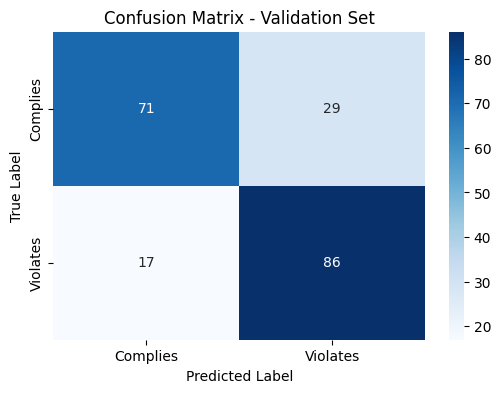

In [70]:
# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Complies', 'Violates'],
            yticklabels=['Complies', 'Violates'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

In [71]:
print(classification_report(valid_labels, valid_preds_binary,
                          target_names=['Complies', 'Violates']))

              precision    recall  f1-score   support

    Complies       0.81      0.71      0.76       100
    Violates       0.75      0.83      0.79       103

    accuracy                           0.77       203
   macro avg       0.78      0.77      0.77       203
weighted avg       0.78      0.77      0.77       203



In [72]:
# Get best checkpoint with fallback
if trainer.state.best_model_checkpoint is not None:
    best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
    print(f"The best model was saved at step {best_model_checkpoint_step}.")
else:
    # Fallback to last checkpoint
    checkpoints = sorted([d for d in model_folder.iterdir() if d.name.startswith('checkpoint-')])
    if checkpoints:
        best_model_checkpoint_step = checkpoints[-1].name.split('-')[-1]
        print(f"Using last checkpoint at step {best_model_checkpoint_step}.")
    else:
        raise ValueError("No checkpoints found!")

checkpoint_path = str(model_folder / f'checkpoint-{best_model_checkpoint_step}')

The best model was saved at step 120.


<font color = 'indianred'> *Save the Best Checkpoint to HuggingFace Hub*</font>

## Description
Save the best-performing model checkpoint to HuggingFace Hub for:
- Future use without retraining
- Sharing with collaborators
- Deployment in production
- Community contributions

In [73]:
# Push to HuggingFace Hub
repo_id = "Hugging-GK/jigsaw-binary-gemma"  # Change this to your username
print(f"\nSaving model to HuggingFace Hub: {repo_id}")


Saving model to HuggingFace Hub: Hugging-GK/jigsaw-binary-gemma


In [74]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/gemma_jigsaw_binary/checkpoint-120'

In [75]:
try:
    lora_model.push_to_hub(run_name)
    print("Model pushed to HuggingFace Hub successfully!")

    # Also upload checkpoint folder
    checkpoint_path = str(model_folder / f'checkpoint-{best_model_checkpoint_step}')

    create_repo(
        repo_id=repo_id,
        repo_type="model",
        private=False,
        exist_ok=True
    )

    api = HfApi()
    api.upload_folder(
        folder_path=checkpoint_path,
        repo_id=repo_id,
        repo_type="model",
    )
    print(f"Checkpoint uploaded to {repo_id}")
except Exception as e:
    print(f"Error uploading to HuggingFace: {e}")
    print("Continuing with local model...")

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   6%|6         | 41.9MB /  665MB            

Model pushed to HuggingFace Hub successfully!


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...eckpoint-120/scheduler.pt: 100%|##########| 1.47kB / 1.47kB            

  ...ckpoint-120/rng_state.pth: 100%|##########| 14.6kB / 14.6kB            

  ...point-120/tokenizer.model: 100%|##########| 4.24MB / 4.24MB            

  ...eckpoint-120/optimizer.pt:   3%|3         | 41.8MB / 1.33GB            

  ...adapter_model.safetensors:   6%|6         | 41.9MB /  665MB            

  ...kpoint-120/tokenizer.json: 100%|##########| 34.4MB / 34.4MB            

  ...int-120/training_args.bin: 100%|##########| 5.91kB / 5.91kB            

Checkpoint uploaded to Hugging-GK/jigsaw-binary-gemma


#  <font color = 'indianred'> **7. Performance on Test Set**</font>

## Theory & Explanation

### Test Set Evaluation
The test set is used for **final unbiased evaluation** of model performance. It should:
- Have never been seen during training
- Have never influenced hyperparameter choices
- Represent real-world data distribution

### Evaluation Procedure:
1. Load the best saved checkpoint
2. Make predictions on test set
3. Apply the optimized threshold
4. Calculate metrics: Accuracy, F1, Precision, Recall
5. Generate confusion matrix for analysis

### Key Principle
Test set results provide the true estimate of how the model will perform on new, unseen data in production.

For test set evaluation, we will perform the following steps:

In [76]:
# Reload model from best checkpoint
model_test = AutoPeftModelForSequenceClassification.from_pretrained(
    checkpoint_path,
    num_labels=1,
    problem_type="single_label_classification",
    quantization_config=bnb_config,
    torch_dtype=torch_data_type,
    trust_remote_code=True
)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at google/gemma-2-2b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
peft_config_test = PeftConfig.from_pretrained(checkpoint_path)
base_model_name = peft_config_test.base_model_name_or_path
tokenizer_test = AutoTokenizer.from_pretrained(base_model_name)

if tokenizer_test.pad_token is None:
    tokenizer_test.pad_token = tokenizer_test.eos_token

model_test.eval()
print("Test model loaded successfully!")

Test model loaded successfully!


In [78]:
# Evaluate with optimal threshold
valid_preds_optimal = (valid_probs > optimal_thresholds[0]).astype(int)

print("\nValidation Set Performance with Optimal Threshold:")
print(f"Accuracy: {accuracy_score(valid_labels, valid_preds_optimal):.4f}")
print(f"F1: {f1_score(valid_labels, valid_preds_optimal):.4f}")
print(f"Precision: {precision_score(valid_labels, valid_preds_optimal):.4f}")
print(f"Recall: {recall_score(valid_labels, valid_preds_optimal):.4f}")


Validation Set Performance with Optimal Threshold:
Accuracy: 0.7734
F1: 0.7890
Precision: 0.7478
Recall: 0.8350


## **Test Set Evaluation Results**

### Overview
Evaluate the final model performance on the held-out test set using the optimized threshold.

<font color = 'indianred'> *Test Set Metric Computation*</font>

## Description
Configure and compute metrics for test set evaluation. We define the same metric functions used during training.

In [79]:
# Load evaluation metrics
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')

In [80]:
def compute_metrics(eval_pred):
    """
    Compute metrics for binary classification using default 0.5 threshold
    """
    logits, labels = eval_pred

    # For binary classification with 1 output unit
    if logits.shape[-1] == 1:
        # Apply sigmoid to convert logits to probabilities
        probs = torch.sigmoid(torch.tensor(logits)).numpy().squeeze()
        # Use default 0.5 threshold
        predictions = (probs > 0.5).astype(int)
    else:
        # Multi-class case (shouldn't happen here)
        predictions = np.argmax(logits, axis=-1)

    labels = labels.astype(int)

    # Compute metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='binary')
    precision = precision_metric.compute(predictions=predictions, references=labels, average='binary')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='binary')

    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1'],
        'precision': precision['precision'],
        'recall': recall['recall']
    }

In [81]:
# Resume create new inference run
run = wandb.init(
    project=WANDB_PROJECT,
    entity=WANDB_ENTITY,
    name="part_a_inference_threshold_optimization",
    job_type="inference",
    config={
        "approach": "classification_head",
        "threshold_optimization": True,
        "default_threshold": 0.5,
    },
    tags=["inference", "threshold-optimization"],
)

eval/accuracy,▁▂▆▆██▇█
eval/f1,▁▇▇███▇█
eval/loss,█▄▂▁▁▁▁▁
eval/precision,▁▅▆▆▇▇█▇
eval/recall,▁█▇█▆▇▅▇
eval/runtime,▃▂▂▃▂▂▁█
eval/samples_per_second,▆▇▇▆▇▇█▁
eval/steps_per_second,▆█▇▆▇██▁
test/accuracy,▁
test/f1,▁
+11,...


In [82]:
# After training is complete, optimize threshold on validation set
from scipy.special import expit as sigmoid

print("\n" + "="*80)
print("OPTIMIZING THRESHOLD ON VALIDATION SET")
print("="*80)

valid_output = trainer.predict(tokenized_dataset["valid"])
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits).squeeze()  # Shape: (203,)
valid_labels = valid_output.label_ids.astype(int)

def find_best_threshold_binary(probabilities, labels):
    """Find best threshold for binary classification that maximizes F1 score"""
    from sklearn.metrics import f1_score

    # Try different thresholds
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1 = 0
    best_threshold = 0.5

    for threshold in thresholds:
        preds = (probabilities > threshold).astype(int)
        f1 = f1_score(labels, preds)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

optimal_threshold, best_f1 = find_best_threshold_binary(valid_probs, valid_labels)
print(f"\nOptimal threshold: {optimal_threshold:.4f}")
print(f"Best F1 score with optimal threshold: {best_f1:.4f}")


OPTIMIZING THRESHOLD ON VALIDATION SET



Optimal threshold: 0.5100
Best F1 score with optimal threshold: 0.7890


In [83]:
# Create test trainer
training_args_test = TrainingArguments(
    seed=42,
    output_dir="./results",
    per_device_eval_batch_size=16,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

trainer_test = CustomTrainer(
    model=model_test,
    args=training_args_test,
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer_test,
)

/tmp/ipython-input-1985918927.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer_test = CustomTrainer(


In [84]:
optimal_threshold

np.float64(0.5099999999999998)

<font color = 'indianred'>*Evaluate using Trainer*</font>

In [85]:
from scipy.special import expit as sigmoid
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [86]:

# Get predictions on the test set
test_output = trainer_test.predict(tokenized_dataset["test"])
test_logits = test_output.predictions
test_probs = sigmoid(test_logits).squeeze()  # Shape: (203,)
test_labels = test_output.label_ids.astype(int)

# Apply optimal threshold
test_preds = (test_probs > optimal_thresholds[0]).astype(int)

# Calculate metrics manually
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)

print(f"\nTest Set Results (Optimal Threshold = {optimal_thresholds[0]:.4f}):")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")


Test Set Results (Optimal Threshold = 0.5100):
Accuracy: 0.8177
F1: 0.8263
Precision: 0.8000
Recall: 0.8544


In [87]:
# Apply optimal threshold
test_preds = (test_probs > optimal_threshold).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)

print(f"\nTest Set Results (Optimal Threshold = {optimal_threshold:.4f}):")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")


Test Set Results (Optimal Threshold = 0.5100):
Accuracy: 0.8177
F1: 0.8263
Precision: 0.8000
Recall: 0.8544


In [88]:
free_gpu_memory()

GPU memory has been freed.


In [89]:
# Log optimal threshold
wandb.log({
    "optimal_threshold": optimal_threshold,
    "default_f1_0.5": eval_results['eval_f1'],  # F1 with 0.5 threshold
    "optimal_f1": best_f1,
    "threshold_improvement": best_f1 - eval_results['eval_f1'],
})

# Log threshold vs F1 curve
thresholds_to_plot = np.arange(0.1, 0.9, 0.01)
f1_scores = []
for threshold in thresholds_to_plot:
    preds = (valid_probs.squeeze() > threshold).astype(int)
    f1 = f1_score(valid_labels, preds)
    f1_scores.append(f1)

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds_to_plot, f1_scores)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal: {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Classification Threshold')
plt.legend()
plt.grid(True)
wandb.log({"threshold_vs_f1_curve": wandb.Image(plt)})
plt.close()

<font color = 'indianred'> *Analyze Test Set Confusion Matrix*</font>

## Description
Generate and visualize confusion matrix for test set predictions to analyze model performance on unseen data.


Confusion Matrix:
[[78 22]
 [15 88]]


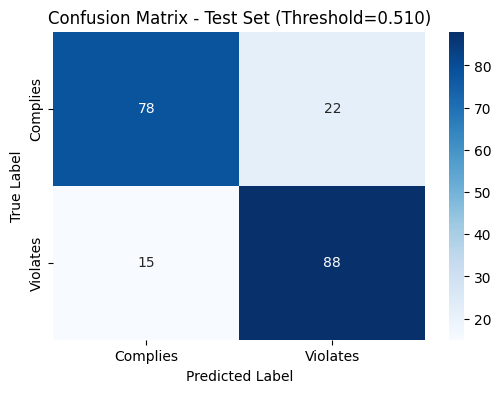


Classification Report:
              precision    recall  f1-score   support

    Complies       0.84      0.78      0.81       100
    Violates       0.80      0.85      0.83       103

    accuracy                           0.82       203
   macro avg       0.82      0.82      0.82       203
weighted avg       0.82      0.82      0.82       203



In [90]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(test_labels, test_preds)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Complies', 'Violates'],
            yticklabels=['Complies', 'Violates'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix - Test Set (Threshold={optimal_threshold:.3f})')
plt.show()

print("\nClassification Report:")
print(classification_report(test_labels, test_preds,
                          target_names=['Complies', 'Violates']))

In [91]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_results = trainer_test.evaluate()


Evaluating on test set...


In [92]:
test_results

{'eval_loss': 0.45838913321495056,
 'eval_model_preparation_time': 0.0051,
 'eval_accuracy': 0.8078817733990148,
 'eval_f1': 0.8186046511627907,
 'eval_precision': 0.7857142857142857,
 'eval_recall': 0.8543689320388349,
 'eval_runtime': 4.3515,
 'eval_samples_per_second': 46.651,
 'eval_steps_per_second': 2.987}

In [99]:
wandb.log({"test_reslts": test_results["eval_f1"]})

In [93]:
test_output = trainer.predict(tokenized_dataset["test"])

In [94]:
test_preds = np.array((test_output.predictions > 0).astype(int))
test_labels = np.array(test_output.label_ids.astype(int))



Confusion Matrix:
[[76 24]
 [15 88]]


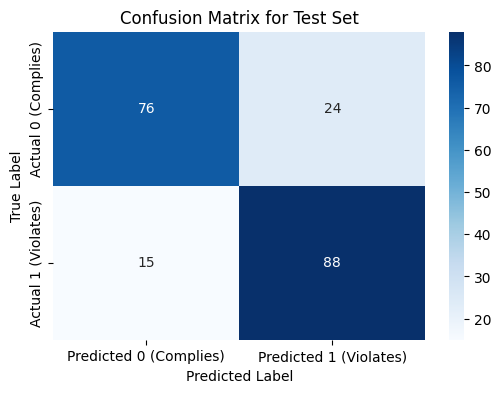


Classification Report:
              precision    recall  f1-score   support

    complies       0.84      0.76      0.80       100
    violates       0.79      0.85      0.82       103

    accuracy                           0.81       203
   macro avg       0.81      0.81      0.81       203
weighted avg       0.81      0.81      0.81       203



In [95]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix for binary classification
conf_matrix = confusion_matrix(test_labels, test_preds)

print("\nConfusion Matrix:")
print(conf_matrix)

# Display the confusion matrix as a heatmap for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0 (Complies)', 'Predicted 1 (Violates)'],
            yticklabels=['Actual 0 (Complies)', 'Actual 1 (Violates)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['complies', 'violates']))

In [100]:
# Log optimal threshold
wandb.log({
    "optimal_threshold": optimal_threshold,
    "default_f1_0.5": test_results['eval_f1'],  # F1 with 0.5 threshold
    "optimal_f1": best_f1,
    "threshold_improvement": best_f1 - test_results['eval_f1'],
})

# Log threshold vs F1 curve
thresholds_to_plot = np.arange(0.1, 0.9, 0.01)
f1_scores = []
for threshold in thresholds_to_plot:
    preds = (valid_probs.squeeze() > threshold).astype(int)
    f1 = f1_score(valid_labels, preds)
    f1_scores.append(f1)

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds_to_plot, f1_scores)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal: {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Classification Threshold')
plt.legend()
plt.grid(True)
wandb.log({"threshold_vs_f1_curve": wandb.Image(plt)})
plt.close()

In [101]:
wandb.finish()

default_f1_0.5,▁█
optimal_f1,▁▁
optimal_threshold,▁▁
test/accuracy,▁█
test/f1,▁█
test/loss,█▁
test/precision,▁█
test/recall,▁█
test/runtime,█▁
test/samples_per_second,▁█
+3,...


# <font color = 'indianred'> **8. Model Inference & Prediction on Competition Data**</font>

## Theory & Explanation

### Inference vs. Training
- **Training**: Learn model parameters using labeled data
- **Inference**: Use trained model to predict on new, unlabeled data

### Inference Pipeline:
1. Load the best trained model and tokenizer
2. Preprocess competition test data the same way as training data
3. Tokenize using the same tokenizer
4. Pass through model to get logits
5. Convert logits to probabilities using sigmoid
6. Apply optimized threshold to get binary predictions
7. Save predictions for submission

### Important Considerations:
- **Consistency**: Preprocess inference data identically to training data
- **Batch Processing**: Process data in batches for memory efficiency
- **Threshold Application**: Use the optimized threshold found on validation set
- **Output Format**: Match submission format exactly

In [102]:
# Prepare  test data
test_competition_df['text'] = test_competition_df.apply(create_input_text, axis=1)
competition_dataset = Dataset.from_pandas(test_competition_df[['text']])

In [103]:
# Tokenize competition test set
competition_tokenized = competition_dataset.map(tokenize_fn, batched=True)
competition_tokenized = competition_tokenized.remove_columns(['text'])
competition_tokenized.set_format(type='torch')

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [104]:
print(f"\nCompetition test set size: {len(competition_tokenized)}")



Competition test set size: 10


In [105]:
# Create pipeline for inference
custom_pipeline = pipeline(
    task="text-classification",
    model=model_test,
    tokenizer=tokenizer_test,
)

Device set to use cuda:0


In [106]:
# Get predictions
competition_preds = []
batch_size = 16

<font color = 'indianred'> **Batch Prediction on Competition Test Data**</font>

## Description
Process the entire competition test set in batches and generate predictions using the trained pipeline.

In [107]:
for i in range(0, len(competition_tokenized), batch_size):
    batch = competition_tokenized[i:i+batch_size]
    texts = tokenizer_test.batch_decode(batch['input_ids'], skip_special_tokens=True)

    results = custom_pipeline(texts, truncation=True, max_length=512)

    # Extract probabilities
    for result in results:
        # Pipeline returns probability for positive class
        if isinstance(result, list):
            result = result[0]
        prob = result['score'] if result['label'] == 'LABEL_1' else 1 - result['score']
        competition_preds.append(prob)

    if (i // batch_size) % 10 == 0:
        print(f"Processed {i}/{len(competition_tokenized)} samples...")

#from probabilty use the threshold to get the output.

Processed 0/10 samples...


In [108]:
# Create submission DataFrame
submission_df = pd.DataFrame({'row_id': test_competition_df['row_id'], 'rule_violation': results})

# Save submission file
submission_path = base_folder / 'submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"\nSubmission file created at: {submission_path}")
print("\nFirst few rows of the submission file:")
print(submission_df.head())


Submission file created at: /content/drive/MyDrive/datasets/submission.csv

First few rows of the submission file:
   row_id                                     rule_violation
0    2029  {'label': 'LABEL_0', 'score': 0.33111974596977...
1    2030  {'label': 'LABEL_0', 'score': 0.37387582659721...
2    2031  {'label': 'LABEL_0', 'score': 0.6610482335090637}
3    2032  {'label': 'LABEL_0', 'score': 0.6201616525650024}
4    2033  {'label': 'LABEL_0', 'score': 0.7490872144699097}


In [109]:
free_gpu_memory()

GPU memory has been freed.


### **Evaluation on Competition Test Data**

## Theory & Explanation

### Competition Data
The competition test data is separate from our train/validation/test splits. It represents completely new, unseen data.

### Evaluation Steps:
1. Preprocess competition test data consistently
2. Tokenize using the same tokenizer
3. Load model and make predictions
4. Apply learned threshold
5. Generate submission with predictions

### Key Differences from Internal Test Set:
- No ground truth labels available
- May have different distribution than training data
- Represents real production scenario
- Results will be evaluated by competition organizers

Now that we have evaluated the model on our held-out test set, let's make predictions on the original competition test data and generate a submission.

In [110]:
# Preprocess the competition test data
test_competition_df['text'] = test_competition_df.apply(create_input_text, axis=1)

# Create a HuggingFace dataset from the competition test data
competition_test_dataset = Dataset.from_pandas(test_competition_df[['text']])

# Tokenize the competition test dataset
tokenized_competition_test_dataset = competition_test_dataset.map(tokenize_fn, batched=True)
tokenized_competition_test_dataset = tokenized_competition_test_dataset.remove_columns(['text'])
tokenized_competition_test_dataset.set_format(type='torch')

print("\nTokenized competition test dataset:")
print(tokenized_competition_test_dataset)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]


Tokenized competition test dataset:
Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 10
})


*Evaluate using Trainer on Competition Test Data*

## Description
Use the Trainer to evaluate the model on competition test data and get comprehensive metrics.

In [111]:
# Use the existing trainer_test initialized with the test model
# Evaluate on the competition test dataset
print("\nEvaluating on competition test set...")
competition_test_results = trainer_test.evaluate(tokenized_competition_test_dataset)


Evaluating on competition test set...


In [113]:
print("\nCompetition Test Results:")
for key, value in competition_test_results.items():
    print(f"{key}: {value:.4f}")



Competition Test Results:
eval_model_preparation_time: 0.0051
eval_runtime: 0.2591
eval_samples_per_second: 38.5930
eval_steps_per_second: 3.8590


In [114]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the competition test set
competition_test_output = trainer_test.predict(tokenized_competition_test_dataset)

# Get probabilities from logits
competition_test_logits = competition_test_output.predictions
competition_test_probs = torch.sigmoid(torch.tensor(competition_test_logits)).numpy().squeeze()

# Apply the optimal threshold to get predictions
competition_test_preds = (competition_test_probs > optimal_thresholds[0]).astype(int)

# For the competition, you would typically submit the predictions
competition_test_preds

array([0, 0, 1, 1, 1, 0, 1, 0, 0, 1])

## Analysis of Rule Violations

### Predicted Violations
Examine examples where the model predicted violations to understand what patterns it learned.

In [115]:
# Filter the test_competition_df where the predicted label is 'violates' (1)
predicted_violates_indices = [i for i, pred in enumerate(competition_test_preds) if pred == 1]
predicted_violates_df = test_competition_df.iloc[predicted_violates_indices]

# Display the body and predicted label for these predictions
print("Competition Test Data where the model predicted 'Violates':")
# Create a column for predicted label for display purposes
predicted_violates_df['predicted_label'] = 'violates'
display(predicted_violates_df[['body', 'predicted_label']])

Competition Test Data where the model predicted 'Violates':


/tmp/ipython-input-4215793367.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_violates_df['predicted_label'] = 'violates'


,body,predicted_label
2,Kickin' ass and selling underwear!\nJust made ...,violates
3,watch hooters best therein http://clickan...,violates
4,bitches for free at this point show all h...,violates
6,WIN A SAMSUNG SMARTWATCH!\n\nhttp://www.innomd...,violates
9,Free paypal cards here!! https://www.pointspri...,violates


## Analysis of Compliant Comments

### Predicted Complies
Examine examples where the model predicted compliance to validate the model's decision-making process.

In [116]:
# Filter the test_competition_df where the predicted label is 'violates' (1)
predicted_violates_indices = [i for i, pred in enumerate(competition_test_preds) if pred == 0]
predicted_violates_df = test_competition_df.iloc[predicted_violates_indices]

# Display the body and predicted label for these predictions
print("Competition Test Data where the model predicted 'Compiles':")
# Create a column for predicted label for display purposes
predicted_violates_df['predicted_label'] = 'Compiles'
display(predicted_violates_df[['body', 'predicted_label']])

Competition Test Data where the model predicted 'Compiles':


/tmp/ipython-input-632382951.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_violates_df['predicted_label'] = 'Compiles'


,body,predicted_label
0,NEW RAP GROUP 17. CHECK US OUT https://soundcl...,Compiles
1,Make your life comfortable. Get up to 15% Disc...,Compiles
5,Top 10 Pentakills in August https://youtu.be/Z...,Compiles
7,[This mixtape is lit FAM!](https://beholdthear...,Compiles
8,must be watch movie https://sites.google.com/s...,Compiles


In [117]:
free_gpu_memory()

GPU memory has been freed.
